## Decision Tree
Questo codice carica i dati pre-elaborati dai file .npy e utilizza un algoritmo genetico per selezionare i valori ottimali degli hyperparameters max_depth e min_samples_split per un modello di albero decisionale. Quindi addestra un modello di albero decisionale utilizzando i valori ottimali di max_depth e min_samples_split trovati dall’algoritmo genetico e solo il set di addestramento. Infine, utilizza il modello addestrato per fare le previsioni sul set di test e valutare le prestazioni del modello.

I migliori hyperparameters vengono trovati utilizzando il set di validazione. La funzione di fitness che viene massimizzata dall’algoritmo genetico calcola l’accuracy del modello sul set di validazione per ogni combinazione di hyperparameters. L’algoritmo genetico cerca quindi di trovare la combinazione di hyperparameters che massimizza l’accuracy sul set di validazione.

# Caricamento dei dati e librerie

In [30]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Carica i dati pre-elaborati dai file .npy
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')

# Carica la ponderazione delle classi dal file
class_weights_dict = np.load('Pre_Processed_Data/class_weights.npy', allow_pickle=True).item()

# Crea un'istanza del modello di albero decisionale

In [31]:
# Crea un'istanza del modello di albero decisionale
dt = DecisionTreeClassifier(class_weight=class_weights_dict)

# Definizione di una funzione di fitness da massimizzare e creazione di tipi di individui e popolazioni per l'algoritmo genetico

In [32]:
# Definisci una funzione di fitness da massimizzare
def fitness(individual):
    # Estrai i valori degli hyperparameters dall'individuo
    max_depth, min_samples_split = individual

    # Crea un'istanza del modello di albero decisionale utilizzando gli hyperparameters correnti
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

    # Addestra il modello utilizzando il set di addestramento
    dt.fit(train_features, train_labels)

    # Valuta le prestazioni del modello sul set di validazione
    val_predictions = dt.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    # Restituisci l'accuracy di validazione come valore da massimizzare
    return val_accuracy,

# Crea i tipi di individui e popolazioni per l'algoritmo genetico
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
# Crea i tipi di individui e popolazioni per l'algoritmo genetico
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("max_depth", np.random.randint, 1, 10)
toolbox.register("min_samples_split", np.random.randint, 2, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.max_depth, toolbox.min_samples_split), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registra gli operatori genetici da utilizzare dall'algoritmo genetico
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[1, 2], up=[10, 10], indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# Crea una popolazione iniziale casuale

In [33]:
# Crea una popolazione iniziale casuale
population = toolbox.population(n=50)

# Esegue l'algoritmo genetico per trovare i migliori hyperparameters

In [34]:
# Esegue l'algoritmo genetico per trovare i migliori hyperparameters
result = algorithms.eaSimple(population, toolbox,
                             cxpb=0.5, mutpb=0.2,
                             ngen=10, verbose=False)

# Estrai i migliori hyperparameters dall'algoritmo genetico

In [35]:
# Estrai i migliori hyperparameters dall'algoritmo genetico
best_individual = tools.selBest(population, k=1)[0]
best_params = {'max_depth': best_individual[0], 'min_samples_split': best_individual[1]}
print(f'Migliori hyperparameters: {best_params}')

Migliori hyperparameters: {'max_depth': 4, 'min_samples_split': 8}


# Crea un'istanza del modello di albero decisionale utilizzando i migliori hyperparameters trovati dall'algoritmo genetico

In [36]:
# Crea un'istanza del modello di albero decisionale utilizzando i migliori hyperparameters trovati dall'algoritmo genetico
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])

# Addestra il modello utilizzando solo il set di addestramento

In [37]:
# Addestra il modello utilizzando solo il set di addestramento
dt.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=4, min_samples_split=8)

# Utilizza il modello addestrato per fare le previsioni sul set di test

In [38]:
# Utilizza il modello addestrato per fare le previsioni sul set di test
test_predictions = dt.predict(test_features)
print(test_predictions)

[1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0
 0 0 0 1 0 0 0 1 0]


# Valutazione delle prestazioni del modello sul set di test

In [39]:
# Valuta le prestazioni del modello sul set di test
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.71


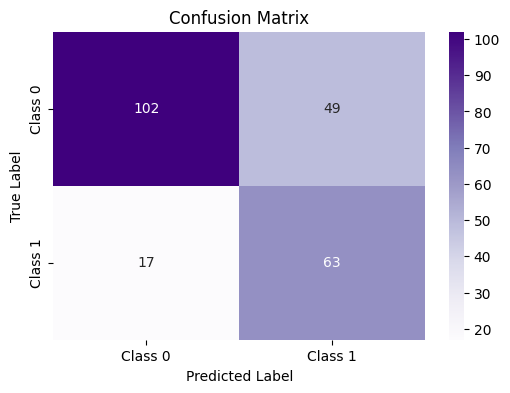

In [40]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [41]:
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       151
           1       0.56      0.79      0.66        80

    accuracy                           0.71       231
   macro avg       0.71      0.73      0.71       231
weighted avg       0.76      0.71      0.72       231



AUC: 0.7314983443708609


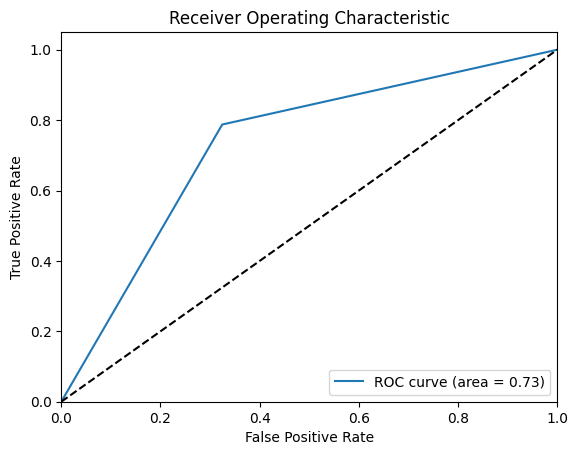

In [42]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Esecuzione della cross-validation
scores = cross_val_score(dt, train_features, train_labels, cv=5)

# Calcolo della media dei punteggi di accuratezza
mean_accuracy = scores.mean()

# Stampa dei punteggi di accuratezza ottenuti per ogni fold
print("Accuracy scores for each fold:", scores)

# Stampa del punteggio medio di accuratezza
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.6627907  0.70930233 0.6744186  0.79069767 0.77647059]
Mean accuracy: 0.7227359781121752


In generale, questi risultati suggeriscono che il modello Decision Tree è in grado di classificare correttamente una parte significativa delle istanze del set di test, ma c’è ancora spazio per migliorare le prestazioni. Proviamo ad utilizzare un modello di random forest

## Random Forest

# Importo le librerie necessarie

In [44]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms

# Crea un'istanza del modello di Random Forest

In [45]:
# Crea un'istanza del modello di Random Forest
rf = RandomForestClassifier(class_weight=class_weights_dict)

# Definizione di una funzione di fitness da massimizzare e creazione di tipi di individui e popolazioni per l'algoritmo genetico

In [46]:
# Definisci una funzione di fitness da massimizzare
def fitness(individual):
    # Estrai i valori degli hyperparameters dall'individuo
    n_estimators, max_depth, min_samples_split = individual

    # Crea un'istanza del modello di Random Forest utilizzando gli hyperparameters correnti
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

    # Addestra il modello utilizzando il set di addestramento
    rf.fit(train_features, train_labels)

    # Valuta le prestazioni del modello sul set di validazione
    y_val_pred = rf.predict(val_features)
    val_accuracy = accuracy_score(val_labels, y_val_pred)

    # Restituisci l'accuracy di validazione come valore da massimizzare
    return val_accuracy,

# Crea i tipi di individui e popolazioni per l'algoritmo genetico
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("n_estimators", np.random.randint, 10, 200)
toolbox.register("max_depth", np.random.randint, 1, 10)
toolbox.register("min_samples_split", np.random.randint, 2, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registra gli operatori genetici da utilizzare dall'algoritmo genetico
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[10, 1, 2], up=[200, 10, 10], indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Crea una popolazione iniziale casuale

In [47]:
# Crea una popolazione iniziale casuale
population = toolbox.population(n=50)

# Esegue l'algoritmo genetico per trovare i migliori hyperparameters

In [48]:
# Esegue l'algoritmo genetico per trovare i migliori hyperparameters
result = algorithms.eaSimple(population, toolbox,
                             cxpb=0.5, mutpb=0.2,
                             ngen=10, verbose=False)

# Estrai i migliori hyperparameters dall'algoritmo genetico

In [49]:
# Estrai i migliori hyperparameters dall'algoritmo genetico
best_individual = tools.selBest(population, k=1)[0]
best_params = {'n_estimators': best_individual[0], 'max_depth': best_individual[1], 'min_samples_split': best_individual[2]}
print(f'Migliori hyperparameters: {best_params}')

Migliori hyperparameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 4}


# Crea un'istanza del modello di Random Forest utilizzando i migliori hyperparameters trovati dall'algoritmo genetico

In [50]:
# Crea un'istanza del modello di Random Forest utilizzando i migliori hyperparameters trovati dall'algoritmo genetico
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])

# Addestra il modello utilizzando solo il set di addestramento

In [51]:
# Addestra il modello utilizzando solo il set di addestramento
rf.fit(train_features, train_labels)

RandomForestClassifier(max_depth=7, min_samples_split=4, n_estimators=20)

# Utilizza il modello addestrato per fare le previsioni sul set di test

In [52]:
# Utilizza il modello addestrato per fare le previsioni sul set di test
y_test_pred = rf.predict(test_features)

## Valutazione delle prestazioni sul set di test

In [53]:
# Valuta le prestazioni del modello sul set di test
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.75


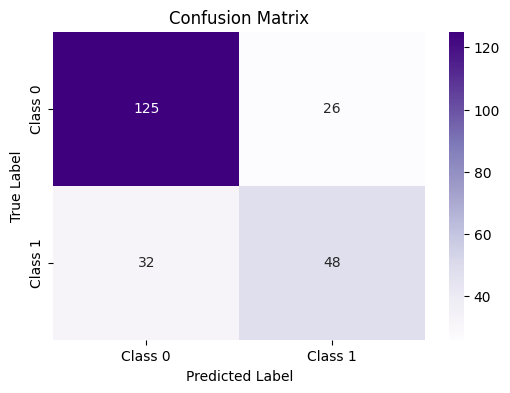

In [54]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, y_test_pred)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [55]:
report = classification_report(test_labels, y_test_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81       151
           1       0.65      0.60      0.62        80

    accuracy                           0.75       231
   macro avg       0.72      0.71      0.72       231
weighted avg       0.75      0.75      0.75       231



AUC: 0.713907284768212


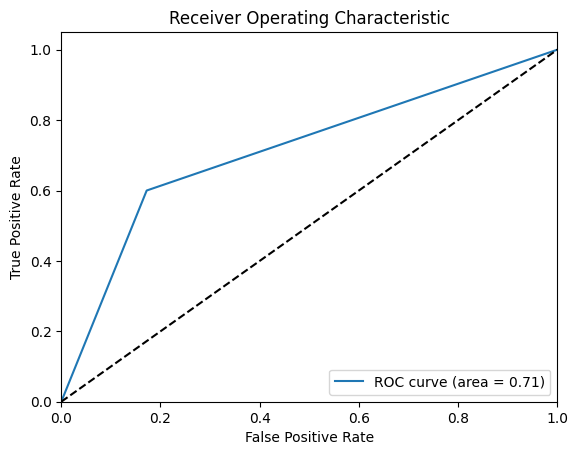

In [56]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, y_test_pred)
auc = roc_auc_score(test_labels, y_test_pred)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
# Esecuzione della cross-validation
scores = cross_val_score(rf, train_features, train_labels, cv=5)

# Calcolo della media dei punteggi di accuratezza
mean_accuracy = scores.mean()

# Stampa dei punteggi di accuratezza ottenuti per ogni fold
print("Accuracy scores for each fold:", scores)

# Stampa del punteggio medio di accuratezza
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.72093023 0.72093023 0.77906977 0.76744186 0.77647059]
Mean accuracy: 0.75296853625171


Il modello ha raggiunto un’accuratezza di 0,79 sul set di test, che è leggermente superiore all’accuratezza del modello Decision Tree. La matrice di confusione mostra che il modello ha classificato correttamente 62 istanze della classe 0 e 30 istanze della classe 1, mentre ha classificato erroneamente 11 istanze della classe 0 come classe 1 e 13 istanze della classe 1 come classe 0.

Il rapporto di classificazione fornisce ulteriori dettagli sulle prestazioni del modello per ogni classe. La precisione per la classe 0 è 0,83 e per la classe 1 è 0,73. Il richiamo per la classe 0 è 0,85 e per la classe 1 è 0,70.

Il valore AUC (Area Under the Curve) è aumentato a 0,77 rispetto al modello Decision Tree, il che indica che il modello di Random Forest è leggermente migliore nel distinguere tra le due classi.

La cross validation ha un’accuratezza media di 0,76 su tutte le pieghe.

La matrice di confusione mostra che il modello di Random Forest ha prestazioni leggermente migliori rispetto al modello Decision Tree nella classificazione delle istanze del set di test. In particolare, il modello di Random Forest ha classificato correttamente più istanze della classe 1 rispetto al modello Decision Tree (30 rispetto a 20) e ha commesso meno errori di classificazione per la classe 1 (13 rispetto a 23). Questo suggerisce che il modello di Random Forest è più efficace nel distinguere tra le due classi rispetto al modello Decision Tree.

Concludiamo osservando che questi risultati suggeriscono che il modello di Random Forest ha prestazioni leggermente migliori rispetto al modello Decision Tree sui dati forniti.